<img src='../img/acam_logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='65%'></img>

<br>

# 1.1 AC SAF - GOME-2 - Level 2 - Formaldehyde (HCHO) data

###  Fire Monitoring - Example Year 2015 - Indonesian Fires

HCHO data are provided by DLR in the framework of the [EUMETSAT Satellite Application Facility on Atmospheric Composition Monitoring (AC SAF)](https://acsaf.org/index.html). Formaldehyde (HCHO) indicates the presence of elevated absorbing aerosols in the Earth's atmosphere. The aerosol types that are mostly seen in the HCHO are desert dust and biomass burning aerosols. 

The data are available in `HDF5` and `BUFR` formats and can be downloaded from the [DLR FTP server](ftp://acsaf.eoc.dlr.de/) after [registration](https://acsaf.org/registration_form.html).

Find more information on the GOME-2 Level 2 HCHO data product on the [AC SAF website](https://acsaf.org/products/oto_hcho.php).

#### Indonesian Fires 2015

In 2015, devastating wildfires broke out in Indonesia. As reported by [Reuters](https://www.reuters.com/article/us-indonesia-politics-haze-analysis-idUSKCN1UV0ZJ), "Between June and October that year, about 2.6 million hectares (6.4 million acres) of land burned in Indonesia, mainly on Sumatra and Borneo islands, said a 2016 World Bank report. A Harvard University study linked the 2015 haze to more than 100,000 premature deaths in Indonesia, Malaysia and Singapore."

#### Module outline:
* [1 - Load and browse AC-SAF GOME-2 Level 2 HCHO data](#load_browse)
* [2 - Open a HDF5 group content as xarray.Dataset object](#open_hcho)
* [3 - Build a xarray.DataArray object for a Metop-A GOME-2 Level 2 parameter](#build_xr_hcho)
* [4 - Combine multiple HDF5 files in a xarray.DataArray object](#combine_hcho)
* [5 - Visualize HCHO values](#visualize)



#### Load required libraries

In [1]:
import os
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

from IPython.display import HTML
# Python libraries for visualisation
from matplotlib import pyplot as plt
from matplotlib import animation


import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
%run ../functions.ipynb

<hr>

## <a id='load_browse'></a>Load and browse GOME-2 Level 2 HCHO data

The AC-SAF Metop-B GOME-2 Level 2 Formaldehyde data is disseminated in the `HDF5` format. [xarray](http://xarray.pydata.org/en/stable/index.html) and [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) are two Python libraries you can use to access and manipulate datasets in `HDF5` format.

### <a id='disover_aah'></a>Discover the structure of AC-SAF Metop-B GOME-2 Level 2 product data files

AC-SAF Metop-B GOME-2 Level 2 data are contained in the folder `/eodata/gome2/hcho/`.

The data in a HDF5 file is organized in groups. Metop-B GOME-2 Level 2 data contain five groups:
* `META_DATA`
 * Product Metadata
* `GEOLOCATION`
 * Date & Time (all retrievals)
 * 4 Corner Coordinates & Centre of Ground Pixel
 * Solar, Line-of-Sight Zenith, and realtive Azimuth angles at TOA
 * Orbit information
* `TOTAL_COLUMNS`
 * Total and tropospheric column amounts of the various trace gases with corresponding (relative) errors
* `DETAILED_RESULTS`
 * Geophysical parameters (surface, cloud and aerosol values)
 * Vertical column, slant column, and AMF values with corresponding errors
 * Fittings diagnostics (chi-square, RMS, etc.)
 * Various subgroups for trace gas specific data (e.g. O<sub>3</sub>, NO<sub>2</sub>, SO<sub>2</sub>, etc.)
* `CLOUD_PROPERTIES`
 * Retrieve cloud properties

You can load a `HDF5` file with the `Dataset` constructor of the [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) library. Load the file in `diskless non-persistent` mode by setting the `diskless` argument to `True` and the `persist` argument to `False`.

The resulting object is a `netCDF4.Dataset` object, which acts like a Python dictionary. Thus, with the `keys` function you can list the different groups the file contains.

In [3]:
file_name = '../eodata/gome2/hcho/2015/09/09/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO-OClO_L2_20150909010045_054_METOPB_15434_DLR_04.HDF5'
file = Dataset(file_name, diskless=True, persist=False)

groups = file.groups.keys()
groups

dict_keys(['CLOUD_PROPERTIES', 'DETAILED_RESULTS', 'GEOLOCATION', 'META_DATA', 'TOTAL_COLUMNS'])

Each group contains multiple variables. You can print out the variables of each group nicely formatted. This gives you a helpful overview of available parameters. You will mostly be interested in parameters of the `TOTAL_COLUMNS` group.

In [4]:
for group in groups:
    print('{}:'.format(group))
    # variables in a group
    variables = sorted(file[group].variables.keys())
    # pretty print of variables in 3 columns
    for v1, v2, v3 in zip(variables[::3], variables[1::3], variables[2::3]):
        print('   - {:<30}- {:<30}- {:<}'.format(v1, v2, v3))
    if (len(variables) % 3) == 1:
        print('   - {:<30}'.format(variables[-1]))
    elif (len(variables) % 3) == 2:
        print('   - {:<30}- {:<}'.format(*variables[-2:]))
    # white line between one line and another
    print()

CLOUD_PROPERTIES:
   - CloudFraction                 - CloudFraction_Error           - CloudMode
   - CloudOpticalThickness         - CloudOpticalThickness_Error   - CloudTopAlbedo
   - CloudTopAlbedo_Error          - CloudTopHeight                - CloudTopHeight_Error
   - CloudTopPressure              - CloudTopPressure_Error        - CloudType
   - PMDCloudFraction              

DETAILED_RESULTS:
   - AAI                           - AMFToCloudTop                 - AMFToCloudTop_Error
   - AMFToGround                   - AMFToGround_Error             - AMFTotal
   - AMFTotal_Error                - ESC                           - ESC_Error
   - FittingChiSquare              - FittingGoodness               - FittingNumberOfIterations
   - FittingRMS                    - IntensityWeightedCloudFraction- QualityFlags
   - SurfaceAlbedo                 - SurfaceConditionFlags         - SurfaceHeight
   - SurfacePressure               - VCD                           - VCD_Error

GEOLOCATI

## <a id='open_hcho'></a>Open a `HDF5` group content as `xarray.Dataset` object

In a next step, you can make use of the `xarray.backends.NetCDF4DataStore` feature of the [xarray](http://xarray.pydata.org/en/stable/index.html) library to open the `HDF5` group you are interested in as a xarray `Dataset` object. It is important to know that you can only get hold of one `HDF5` group item at the time.

As an example, you can load the `TOTAL_COLUMNS` group and open it as xarray `Dataset`. You see that the data has one dimension: `phony_dim_20`.

In [5]:
data = file['TOTAL_COLUMNS']
xr_data = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
xr_data

<xarray.Dataset>
Dimensions:         (phony_dim_20: 15264)
Dimensions without coordinates: phony_dim_20
Data variables:
    BrO             (phony_dim_20) float32 ...
    BrO_Error       (phony_dim_20) float32 ...
    H2O             (phony_dim_20) float32 ...
    H2O_Error       (phony_dim_20) float32 ...
    HCHO            (phony_dim_20) float32 ...
    HCHO_Error      (phony_dim_20) float32 ...
    NO2             (phony_dim_20) float32 ...
    NO2Tropo        (phony_dim_20) float32 ...
    NO2Tropo_Error  (phony_dim_20) float32 ...
    NO2_Error       (phony_dim_20) float32 ...
    O3              (phony_dim_20) float32 ...
    O3_Error        (phony_dim_20) float32 ...
    OClO            (phony_dim_20) float32 ...
    OClO_Error      (phony_dim_20) float32 ...
    SO2             (phony_dim_20) float32 ...
    SO2_Error       (phony_dim_20) float32 ...

<br>

### <a id='select_hcho'></a>Select and retrieve one specific parameter from a `xarray.Dataset` object

We are interested in the `HCHO` parameter, which contains information on the vertical column density of HCHO (cloud screened). With `xarray`, you can retrieve the parameter using square brackets `[]` and the name of the parameter of interest. 

The resulting object is a `xarray.DataArray`, which has the shape of a one-dimensional vector.

The `xarray.DataArray` holds also data attributes, which help a better understanding of the parameter, e.g. you get information about minimum and maximum values of the parameter and the unit of the data values.

In [6]:
hcho = xr_data['HCHO']
hcho

<xarray.DataArray 'HCHO' (phony_dim_20: 15264)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Dimensions without coordinates: phony_dim_20
Attributes:
    Title:          Vertical column density of HCHO
    Unit:           mol/cm2
    CheckSum:       1585008046
    FillValue:      -1.0
    ValueRangeMin:  -3.609892e+16
    ValueRangeMax:  5.0599353e+16

## <a id='build_xr_hcho'></a>Build a `xarray.DataArray` object for a Metop-B GOME-2 Level 2 parameter

For easier handling and plotting of the parameters, you can combine geolocation information and data values in a xarray `DataArray` structure, which can be created with the xarray `DataArray` constructor. 

You can make use of the function `generate_xr_from_1D_vec` which takes the following kwargs:
* `file` - the data file you want to load the data information from
* `lat_path` - internal paths to the latitude information of the HDF5 file
* `lon_path` - internal paths to the longitude information of the HDF5 file
* `variable` - xarray.DataArray with the variable information
* `parameter_name` - Name of the variable
* `longname` - Long name information of the variable
* `no_of_dims` - Number of dimensions of the data file
* `unit` - unit of the variable

We take the centre of the ground pixel as coordinates of the `DataArray`. The values can be retrieved from the internal paths `GEOLOCATION/LatitudeCentre` and `GEOLOCATION/LongitudeCentre` respectively.

The resulting object is a xarray `DataArray` object with latitude and longitude information and the HCHO values as data values. The `DataArray` object contains 15238 ground pixels.

In [7]:
hcho_xr = generate_xr_from_1D_vec(file = file, 
                                 lat_path = 'GEOLOCATION/LatitudeCentre', 
                                 lon_path = 'GEOLOCATION/LongitudeCentre', 
                                 variable = hcho, 
                                 parameter_name = hcho.name, 
                                 longname = hcho.Title,
                                 no_of_dims = 1, 
                                 unit = hcho.Unit)

hcho_xr

<xarray.DataArray 'HCHO' (ground_pixel: 15264)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.68473 65.97052 ... -82.824425 -83.14359
    longitude  (ground_pixel) float32 272.22263 271.68396 ... 91.59158 90.42983
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

You can now continue to visualize the `DataArray` object. You can use the function `visualize_scatter()` to do it. The function combines matplotlib's `scatter` functionality with Cartopy, a powerful library offering different projections for geographical data.

The `visualize_scatter` function takes the following kwargs:
* `xr_dataarray` - xarray.DataArray object
* `conversion_factor` - a number that can be used to convert data values
* `projection` - choose a cartopy projection
* `vmin` - Minimum value in the data range
* `vmax` - Maximum value in the data range
* `point_size` - size of the scatters
* `color_scale` - string of matplotlib's color ramp references
* `unit` - Unit of the data
* `title` - Title of the plot

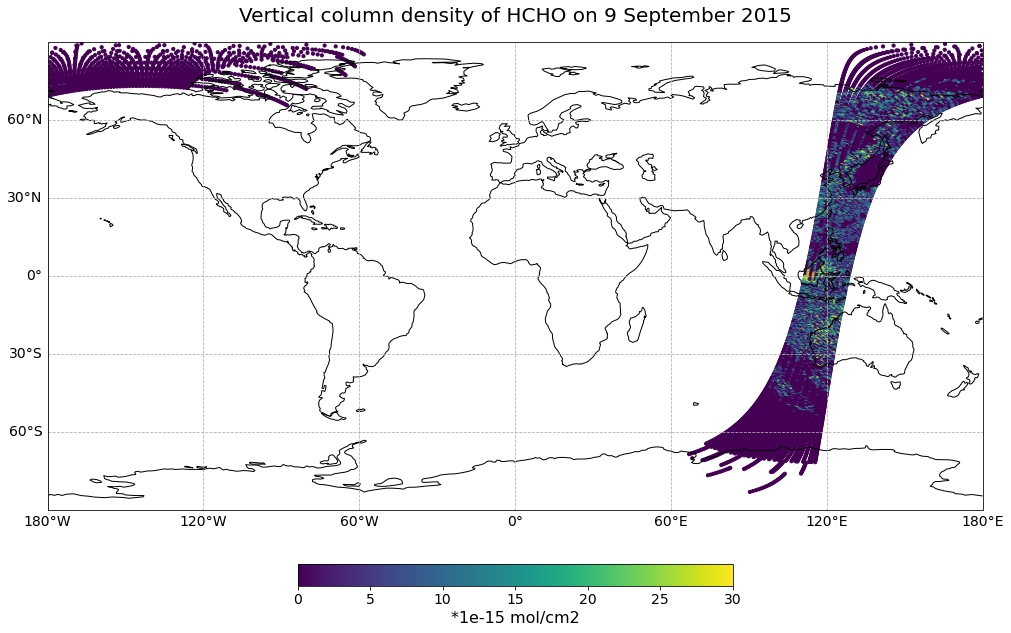

In [8]:
visualize_scatter(xr_dataarray=hcho_xr, 
             conversion_factor=1e-15, 
             projection=ccrs.PlateCarree(),
             vmin=0,
             vmax=30,
             point_size=10,
             color_scale='viridis',
             unit='*1e-15 ' + hcho_xr.units, 
             title=hcho_xr.long_name + ' on 9 September 2015'
                 )

## <a id='combine_hcho'></a>Combine multiple HDF5 files in a `xarray.DataArray` object

AC-SAF Metop-B GOME-2 Level 2 data files for one individual day are stored in multiple files. In order to combine all sensed ground tracks for one individual day, you can apply the function `load_l2_data_xr`, which loads multiple `HDF5` files and returns a `xarray.DataArray` object with all ground pixels of all files. The function makes internally use of the function `generate_xr_from_1D_vec`.

Let us load all the AC-SAF Metop-B GOME-2 Level 2 data files for 9 September 2015. The function takes the following kwargs:
* `directory` - file directory containing the `HDF5` files
* `internal_filepath` - internal filepath containing the data information, e.g. `DATA`
* `parameter` - name of the parameter
* `lat_path` - path to the latitude information in the `HDF5` file
* `lon_path` - path to the longitude information in the `HDF5` file
* `no_of_dims` - Number of dimensions of the file
* `paramname` - Name of variable
* `unit` - Unit of the variable
* `longname` - Long name of the variable

In [9]:
directory='../eodata/gome2/hcho/2015/09/09'
hcho_da_mf = load_l2_data_xr(directory= directory,
                           internal_filepath='TOTAL_COLUMNS',
                           parameter='HCHO',
                           lat_path='GEOLOCATION/LatitudeCentre',
                           lon_path='GEOLOCATION/LongitudeCentre',
                           no_of_dims=1,
                           paramname=hcho.name,
                           unit=hcho.Unit,
                           longname=hcho.Title)

hcho_da_mf

<xarray.DataArray 'HCHO' (ground_pixel: 213285)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.68473 65.97052 ... -83.20291 -83.516525
    longitude  (ground_pixel) float32 272.22263 271.68396 ... 119.426674
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

##  <a id="visualize"></a>Visualize the Metop-B GOME-2 Level 2 HCHO data

If you visualize the data array containing ground pixel information from multiple files, you see that for one day, almost all part on Earth are covered by Metop-B GOME-2. You can again use the function `visualize_scatter` to visualize the data as a scatter plot. 

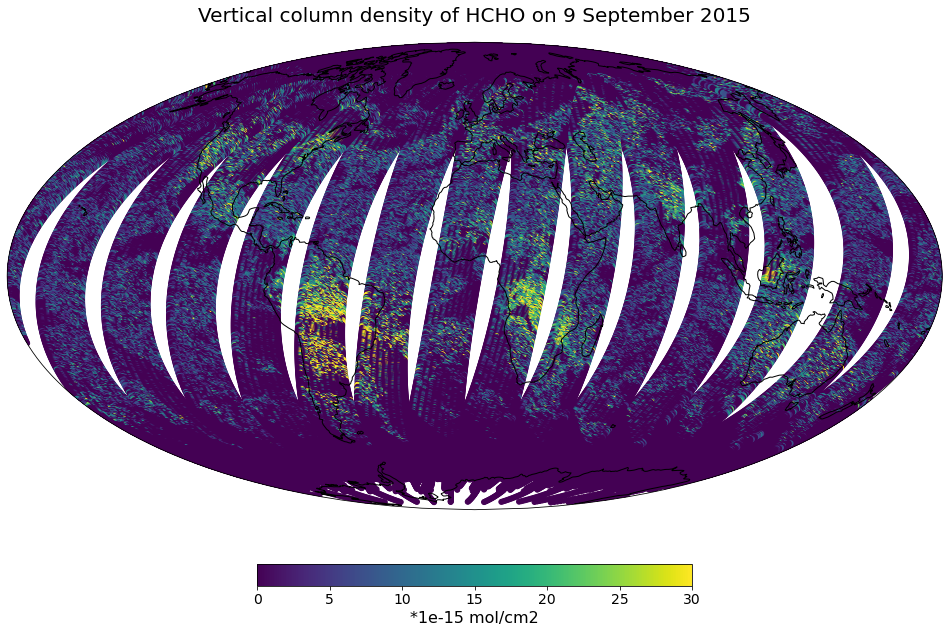

In [10]:
visualize_scatter(xr_dataarray=hcho_da_mf, 
             conversion_factor=1e-15,
             projection=ccrs.Mollweide(), 
             vmin=0, 
             vmax=30, 
             point_size=25, 
             color_scale='viridis', 
             unit='*1e-15 ' + hcho_da_mf.units, 
             title=hcho_da_mf.long_name + " on 9 September 2015"
                 )

Let us visualize the data using the `Orthographic` projection. Take note of the elevated values over the island of Borneo.

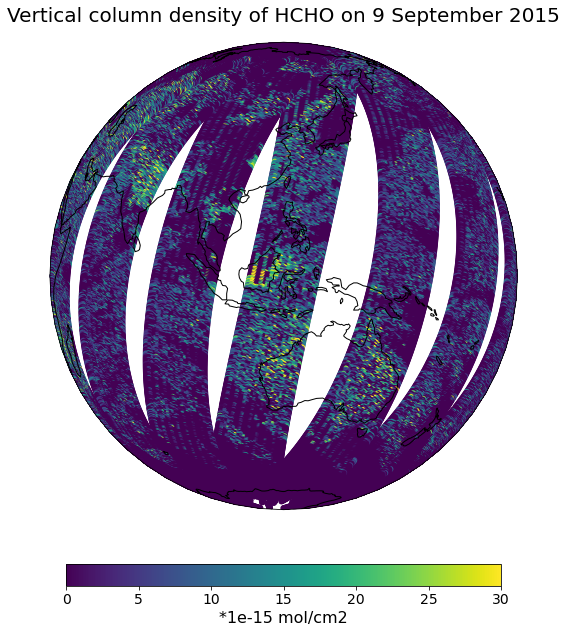

In [11]:
visualize_scatter(xr_dataarray=hcho_da_mf, 
             conversion_factor=1e-15,
             projection=ccrs.Orthographic(120), 
             vmin=0, 
             vmax=30, 
             point_size=25, 
             color_scale='viridis', 
             unit='*1e-15 ' + hcho_da_mf.units, 
             title=hcho_da_mf.long_name + " on 9 September 2015"
                 )

<br>

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="../LICENSE">MIT License</a> and is developed under a Copernicus contract.